### Загрузка данных

Гайд по скачиванию:
https://www.metagenomics.wiki/tools/fastq/ncbi-ftp-genome-download

In [18]:
import gzip

!wget 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.fna.gz'
!wget 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.gbff.gz'

!gunzip GCF_000355675.1_ASM35567v1_genomic.fna.gz
!gunzip GCF_000355675.1_ASM35567v1_genomic.gbff.gz

--2023-11-12 20:25:29--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.fna.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.12, 130.14.250.13, 2607:f220:41e:250::13, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1168222 (1.1M) [application/x-gzip]
Saving to: ‘GCF_000355675.1_ASM35567v1_genomic.fna.gz’

GCF_000355675.1_ASM 100%[===================>]   1.11M  2.08MB/s    in 0.5s    

2023-11-12 20:25:30 (2.08 MB/s) - ‘GCF_000355675.1_ASM35567v1_genomic.fna.gz’ saved [1168222/1168222]

--2023-11-12 20:25:30--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.gbff.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.12, 130.14.250.13, 2607:f220:41e:250::13, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nl

### Reading sequences

In [19]:
!pip install bio

In [20]:
from Bio import SeqIO
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt

seq = None
gb = None

# считываем скачанные файлы
for record in SeqIO.parse("/content/GCF_000355675.1_ASM35567v1_genomic.fna", "fasta"):
    seq = record.seq

for record in SeqIO.parse('/content/GCF_000355675.1_ASM35567v1_genomic.gbff', 'genbank'):
  gb = record

In [21]:
start, end = gb.features[0].location.start, None

ncod = []
cod = []

# записываем кодирующие и некодирующие последовательности
for i in range(len(gb.features)):
  feature = gb.features[i]
  fseq = feature.extract(seq)

  end = feature.location.start

  if feature.type == 'CDS' and fseq[:3] == 'ATG' and len(fseq) % 3 == 0:
    cod.append(fseq.__str__())

    if len(seq[start:end]) != 0:
      ncod.append(seq[start:end].__str__())

    start = feature.location.end

### Initial probabilities

In [22]:
def seq_probs(seq):
  return np.array([
      seq.count('T'), seq.count('C'),
      seq.count('A'), seq.count('G')
    ]) / len(seq)

def cod_probs(seq):
  res = []
  for i in range(3):
    res.append(seq_probs(seq[i::3]))
  return np.array(res)

def make_table1(cod_seqs, ncod_seqs):
  table1 = pd.DataFrame(np.vstack((cod_probs(''.join(cod_seqs)), seq_probs(''.join(ncod_seqs)))).T,
                       index=['T', 'C', 'A', 'G'],
                       columns=[f'pos{i}' for i in range(1, 4)] + ['nc'])
  return table1

In [23]:
t1 = make_table1(cod, ncod)
t1

,pos1,pos2,pos3,nc
T,0.181178,0.296080,0.315009,0.272761
C,0.206735,0.227039,0.233246,0.228978
A,0.256919,0.302102,0.238526,0.276553
G,0.355168,0.174779,0.213219,0.221708


### Transition probabilities

In [24]:
def cod_dprobs(seqs):
  dcounts = dict(
    zip([1, 2, 3],
        [dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                  [0] * 16)) for i in range(3)])
    )
  for seq in seqs:
    for i in range(1, len(seq)):
      dcounts[i % 3 + 1][seq[i-1:i+1]] += 1
  return get_probs(dcounts)

def ncod_dprobs(seqs):
    dcounts =dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                    [0] * 16))
    for seq in seqs:
      for i in range(1, len(seq)):
        dcounts[seq[i-1:i+1]] += 1

    return get_probs({0: dcounts})[0]

def get_probs(dcounts):
  for pos in dcounts:
    nuc_groups = dict(zip('TCAG', [0] * 4))
    for dup in dcounts[pos]:
      nuc_groups[dup[0]] += dcounts[pos][dup]
    for dup in dcounts[pos]:
      dcounts[pos][dup] /= nuc_groups[dup[0]]
  return dcounts

def make_table2(cod_seqs, ncod_seqs):
  table2 = pd.DataFrame(cod_dprobs(cod_seqs))
  table2[4] = pd.Series(ncod_dprobs(ncod_seqs))
  table2.rename(columns=dict(zip(np.arange(1, 5),
                                 [f'pos{i}' for i in range(1, 4)] + ['nc'])),
                inplace=True)
  table2.index = [prob_notation(idx) for idx in table2.index.values]
  return table2

def prob_notation(st):
  return st[1] + '|' + st[0]

In [25]:
t2 = make_table2(cod, ncod)
t2

,pos1,pos2,pos3,nc
T|T,0.185527,0.497941,0.316282,0.317919
C|T,0.189643,0.199367,0.179967,0.209093
A|T,0.249195,0.172458,0.221521,0.243747
G|T,0.375635,0.130234,0.282230,0.229240
T|C,0.185286,0.248599,0.269786,0.252206
C|C,0.156258,0.198068,0.244280,0.213760
A|C,0.276169,0.315114,0.244600,0.286907
G|C,0.382287,0.238219,0.241334,0.247126
T|A,0.179924,0.333963,0.307865,0.269894
C|A,0.194132,0.213885,0.193588,0.205527


TATTACTTC
P(seq NC)=P(T|NC)*Pnc(A|T)*Pnc(T|A)*P(T|T)*P(A|T)...

In [26]:
P_seq_nc = t1['nc']['T'] * t2['nc']['A|T']*t2['nc']['T|A']*t2['nc']['T|T']*t2['nc']['A|T']*t2['nc']['C|A']*t2['nc']['T|C']*t2['nc']['T|T']*t2['nc']['C|T']
P_seq_nc

4.7912814510831735e-06

In [27]:
t2['nc']['A|T']

0.24374699430844582

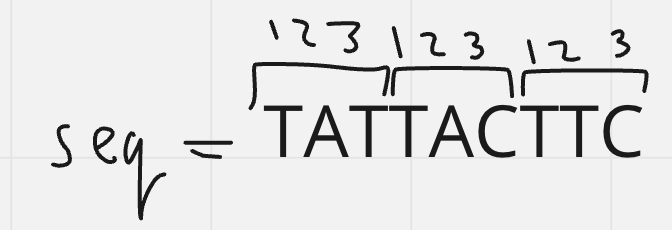

In [28]:
P_seq_cod = t1['pos1']['T']   * t2['pos2']['A|T'] * t2['pos3']['T|A'] * \
            t2['pos1']['T|T'] * t2['pos2']['A|T'] * t2['pos3']['C|A'] * \
            t2['pos1']['T|C'] * t2['pos2']['T|T'] * t2['pos3']['C|T']
P_seq_cod

9.893054273008876e-07

In [29]:
P_nc = 0.5
P_cod = 0.5
P_nc_seq = P_nc * P_seq_nc / (P_nc * P_seq_nc + P_cod * P_seq_cod)
P_nc_seq

0.8288572686278104

In [30]:
P_cod_seq = P_cod * P_seq_cod / (P_nc * P_seq_nc + P_cod * P_seq_cod)
P_cod_seq

0.17114273137218963

In [31]:
1-P_nc_seq

0.1711427313721896

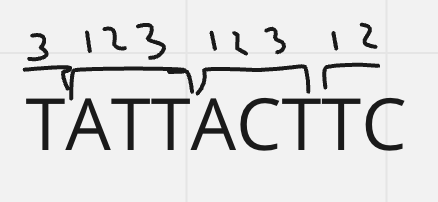

In [32]:
P_seq_cod2 = t1['pos3']['T'] * \
            t2['pos1']['A|T'] * t2['pos2']['T|A'] * t2['pos3']['T|T'] * \
            t2['pos1']['A|T'] * t2['pos2']['C|A'] * t2['pos3']['T|C'] * \
            t2['pos1']['T|T'] * t2['pos2']['C|T']
P_seq_cod2

4.409967752533561e-06

### Prediction

In [35]:
def cod_proba(seq, t1, t2, frame=1):

  if len(seq) == 0:
    print('No sequence')
    return None

  if frame not in [1, 2, 3]:
    print('No such frame')
    return None

  log_prob = np.log(t1[f'pos{frame}'][seq[0]])

  prev_nuc = seq[0]
  for i, nuc in enumerate(seq[1:], 1):
    pos = (frame + i - 1) % 3 + 1
    pair = '{}|{}'.format(nuc, prev_nuc)
    log_prob += np.log(t2[f'pos{pos}'][pair])
    prev_nuc = nuc

  return np.exp(log_prob)

def ncod_proba(seq, t1, t2):
  if len(seq) == 0:
    print('No sequence')
    return None

  log_prob = np.log(t1['nc'][seq[0]])
  prev_nuc = seq[0]
  for i, nuc in enumerate(seq[1:], 1):
    pair = '{}|{}'.format(nuc, prev_nuc)
    log_prob += np.log(t2[f'nc'][pair])
    prev_nuc = nuc

  return np.exp(log_prob)

def get_cod_probs(seq, t1, t2):
  prob1 = cod_proba(seq, t1, t2, frame=1)
  prob2 = cod_proba(seq, t1, t2, frame=2)
  prob3 = cod_proba(seq, t1, t2, frame=3)
  probnc = ncod_proba(seq, t1, t2)
  total = prob1 + prob2 + prob3 + probnc
  return {
      'prob1': prob1 / total,
      'prob2': prob2 / total,
      'prob3': prob3 / total,
      'probnc': probnc / total
    }

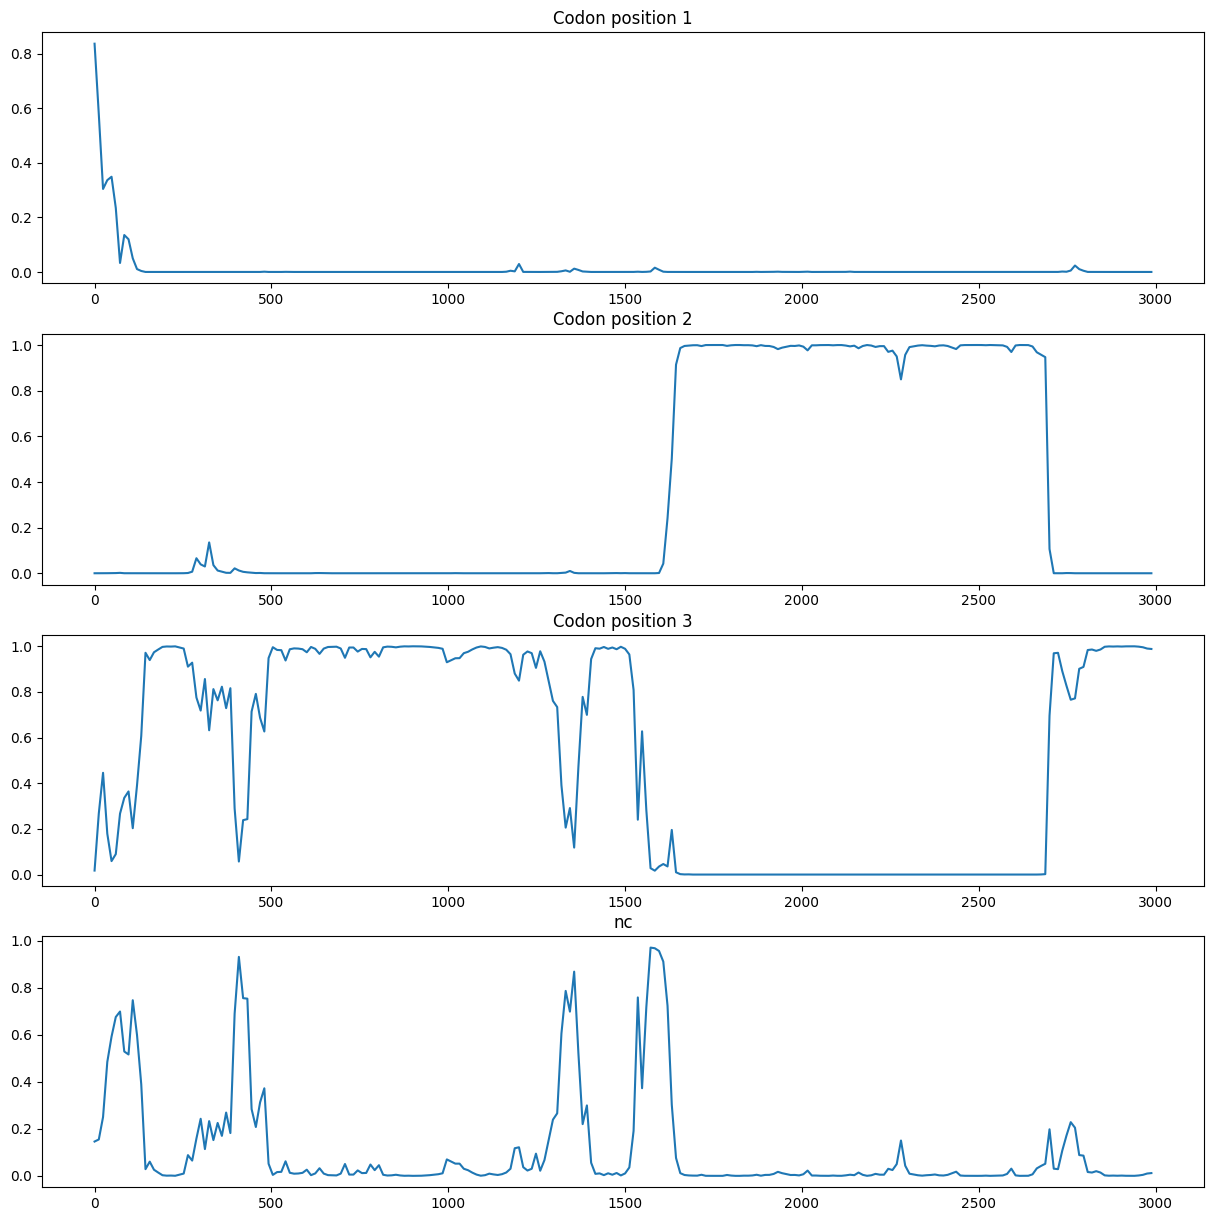

In [45]:
def plot_graph(data, start, end, step):
  fig, (ax1, ax2, ax3, axnc) = plt.subplots(4, 1, figsize=(15, 15))

  x = range(start, end, step)

  ax1.plot(x, data['prob1'])
  ax2.plot(x, data['prob2'])
  ax3.plot(x, data['prob3'])
  axnc.plot(x, data['probnc'])

  ax1.set_title('Codon position 1')
  ax2.set_title('Codon position 2')
  ax3.set_title('Codon position 3')
  axnc.set_title('nc')

  plt.plot()


start = 0
end = 3000
step = 12
window = 96
pos_probs = {
  'prob1': [],
  'prob2': [],
  'prob3': [],
  'probnc': [],
}
for i in range(start, end, step):
  cod_probs = get_cod_probs(seq[i: i + window], t1, t2)
  for k, v in cod_probs.items():
    pos_probs[k].append(v)

plot_graph(pos_probs, start, end, step)